***Important note:***  
The code for **training the GCN model** and **explaining its predictions** using **GNNExplainer** is based on the official PyTorch Geometric example, which can be found [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer_link_pred.py).


# **Step 1: Install dependencies & import the necessary libraries**

In [ ]:
#install the required dependencies for PyG
#https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

!pip install torch_geometric
!pip install torch

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
#import libraries
import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, average_precision_score

import networkx as nx
from pyvis.network import Network

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import ipywidgets as widgets
from IPython.display import display

import datetime

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_ba

# **Step 2: Load the graph in a Pandas df**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the csv file (our graph) and load it in a Pandas df for preprocessing
graph = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/full_simpathic_graph.tsv', sep = "\t")

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id
0,Acute respiratory disease,C0264219,MENTIONED_IN,NaN,NaN,37081685
1,Vascular blood supply,C0920762,MENTIONED_IN,NaN,NaN,37081677
2,Low T3 Syndrome,C0024043,HAS_MESH,NaN,CEN case reports,36018508
3,Low T3 Syndrome,C0024043,HAS_MESH,NaN,Georgian medical news,36318859
4,Low T3 Syndrome,C0024043,MENTIONED_IN,NaN,NaN,37081677


In [ ]:
#folders to store the results will contain the datetime, because otherwise the results are overwriten after each run
timestamp_str = datetime.datetime.now().strftime("%d%m%Y_%H%M")
results_dir = "/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results"

feature_importance_dir = os.path.join(results_dir, f"feature_importance_{timestamp_str}")
explanation_graph_dir = os.path.join(results_dir, f"explanation_graph_{timestamp_str}")
pyvis_explanation_graph_dir = os.path.join(results_dir, f"pyvis_explanation_graph_{timestamp_str}")

os.makedirs(feature_importance_dir, exist_ok=True)
os.makedirs(explanation_graph_dir, exist_ok=True)
os.makedirs(pyvis_explanation_graph_dir, exist_ok=True)

# **Step 3: Encoding and mapping the data**
In this step, we need to make the knowledge graph data compatible with GNNs. To do so, we will prepare them by encoding all the nodes and relations into numeric values.

In [ ]:
#find the unique nodes
unique_nodes = pd.Series(pd.concat([graph['ENTITY_A_CUI'], graph['ENTITY_B_CUI_OR_ARTICLE_id']]).unique())
#unique_nodes.head(5)
print(f"Unique nodes in the graph: {unique_nodes.nunique()}")

Unique nodes in the graph: 162907


In [ ]:
#nodes
#map each unique node to a unique numeric ID
node_id_mapping = {node: idx + 1 for idx, node in enumerate(unique_nodes)} #{'C1538301': 1, 'C0185115': 2...}

#adding columns ENTITY_A_ID , ENTITY_B_ID with the numeric IDs we created above
graph['ENTITY_A_ID'] = graph['ENTITY_A_CUI'].map(node_id_mapping)
graph['ENTITY_B_ID'] = graph['ENTITY_B_CUI_OR_ARTICLE_id'].map(node_id_mapping)

#relations
#map each relation to a unique numeric ID
relation_mapping = {relation: idx + 1 for idx, relation in enumerate(graph['RELATION'].unique())}

#adding the RELATION_ENCODED column with the encoded relation ID
graph['RELATION_ENCODED'] = graph['RELATION'].map(relation_mapping)

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id,ENTITY_A_ID,ENTITY_B_ID,RELATION_ENCODED
0,Acute respiratory disease,C0264219,MENTIONED_IN,NaN,NaN,37081685,1,126712,1
1,Vascular blood supply,C0920762,MENTIONED_IN,NaN,NaN,37081677,2,126713,1
2,Low T3 Syndrome,C0024043,HAS_MESH,NaN,CEN case reports,36018508,3,126714,2
3,Low T3 Syndrome,C0024043,HAS_MESH,NaN,Georgian medical news,36318859,3,126715,2
4,Low T3 Syndrome,C0024043,MENTIONED_IN,NaN,NaN,37081677,3,126713,1


# **Step 4: Creating the nodes and edges files for PyTorch Geometric**
The next steps include training a GCN model and then applying GNNExplainer. To do so, we need the following files to construct the graph in PyG:


1. **nodes.csv**
   * Mapping of node IDs to their labels
  
2. **edges.csv**
   * The relations between nodes



In [ ]:
#declaring the output directory for storing the csv files
output_dir = "/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/processed_graph_files/"
os.makedirs(output_dir, exist_ok=True)

#use ENTITY_B_CUI_OR_ARTICLE_id if entity_b is null or empty.
#then prefix 'article_id_' was added to make it more readable

graph['ENTITY_B'] = graph.apply(
    lambda row: f"article_id_{row['ENTITY_B_CUI_OR_ARTICLE_id']}"
    if pd.isna(row['ENTITY_B']) or row['ENTITY_B'] == ""
    else row['ENTITY_B'],
    axis=1
)

#nodes.csv
#map node IDs with their node labels
node_label_mapping = dict(zip(graph['ENTITY_A_ID'], graph['ENTITY_A']))
node_label_mapping.update(dict(zip(graph['ENTITY_B_ID'], graph['ENTITY_B'])))

node_label_mapping = {node_id - 1: label for node_id, label in node_label_mapping.items()}

#dictionary to df, so that we can save it in csv format
node_label_df = pd.DataFrame(node_label_mapping.items(), columns=["Node_ID", "Node_Label"])
node_label_df.to_csv(os.path.join(output_dir, "nodes.csv"), index=False, sep=" ")

#edges.csv
#keep the columns i need for training the model and rename them for PyG
edges_df = graph[['ENTITY_A_ID', 'ENTITY_B_ID', 'RELATION_ENCODED']].rename(
    columns={'ENTITY_A_ID': 'Source', 'ENTITY_B_ID': 'Target', 'RELATION_ENCODED': 'Relation_Label'}
)
edges_df.to_csv(os.path.join(output_dir, "edges.csv"), index=False)

In [ ]:
node_label_df.head(5)

,Node_ID,Node_Label
0,0,Acute respiratory disease
1,1,Vascular blood supply
2,2,Low T3 Syndrome
3,3,POLYGLANDULAR DISORDER
4,4,Empty Sella Syndrome


In [ ]:
edges_df.head(5)

,Source,Target,Relation_Label
0,1,126712,1
1,2,126713,1
2,3,126714,2
3,3,126715,2
4,3,126713,1


# **Step 5: Preparing the data for the GCN model and the GNNExplainer**  
This step consists of processing the data in a suitable format for PyG.

In [ ]:
#use GPU (CUDA) if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load the nodes and edges files
nodes_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/processed_graph_files/nodes.csv", sep=" ")
edges_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/processed_graph_files/edges.csv")

#-1 on every node id to have correct mapping
nodes_df["Node_ID"] = nodes_df["Node_ID"] - 1

display(nodes_df)

,Node_ID,Node_Label
0,-1,Acute respiratory disease
1,0,Vascular blood supply
2,1,Low T3 Syndrome
3,2,POLYGLANDULAR DISORDER
4,3,Empty Sella Syndrome
...,...,...
162902,162901,article_id_25323647
162903,162902,article_id_26474496
162904,162903,article_id_27683811
162905,162904,article_id_38409492


In [ ]:
#node mapping

#find all the unique node IDs from edges_df
unique_nodes = sorted(set(edges_df["Source"]).union(set(edges_df["Target"])))

#new method to resolve error: PyG requires continuous node indices
#mapping to have a sequential index to each unique node ID
node_mapping_fixed = {
    node_id: node_id
    for node_id in nodes_df["Node_ID"].unique()
}

#add Mapped_ID in the nodes df with the new sequential IDs
nodes_df["Mapped_ID"] = nodes_df["Node_ID"].map(node_mapping_fixed)

#apply new mapping logic
edges_df["Source"] = edges_df["Source"] - 1
edges_df["Target"] = edges_df["Target"] - 1

edges_df.head()

,Source,Target,Relation_Label
0,0,126711,1
1,1,126712,1
2,2,126713,2
3,2,126714,2
4,2,126712,1


In [ ]:
#mapping of relation labels - it's a reverse mapping (id -> relation) to help with visualizations
relation_label_mapping = {idx+1: relation for idx, relation in enumerate(graph['RELATION'].unique())}

In [ ]:
#node embeddings - each node will have a 128 dim embedding vector
num_nodes = len(unique_nodes)

#number of features per node
embedding_dim = 128
#embedding layer for nodes
node_embeddings = torch.nn.Embedding(num_nodes, embedding_dim)

#embeddings weights
# x is the node feature matrix we will use in our GCN model
x = node_embeddings.weight

#PyTorch tensors will be used in order to create the PyG data object
#edges
edge_index = torch.tensor(edges_df[['Source', 'Target']].values.T, dtype=torch.long)
#indicate that every edge in the dataset is a positive edge
edges_df['Label'] = 1

#edge labels
edge_labels = torch.tensor(edges_df['Label'].values, dtype=torch.long)

#PyTorch Geometric data object
#in this variable we store the graph in a PyG format
data = Data(x=x, edge_index=edge_index, edge_label=edge_labels).to(device)

# **Step 6: Split the data in training, validation and testing sets**  

In [ ]:
#splitting data in training, validation and testing sets
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    is_undirected=True,
    add_negative_train_samples=True #to generate false edges during training
)

#apply the transformation to the data obj
train_data, val_data, test_data = transform(data)

print(f"train_data: {train_data}")
print(f"val_data: {val_data}")
print(f"test_data: {test_data}")

train_data: Data(x=[162907, 128], edge_index=[2, 3598002], edge_label=[3598002], edge_label_index=[2, 3598002])
val_data: Data(x=[162907, 128], edge_index=[2, 3598002], edge_label=[514000], edge_label_index=[2, 514000])
test_data: Data(x=[162907, 128], edge_index=[2, 4112002], edge_label=[1028000], edge_label_index=[2, 1028000])


In [ ]:
#lables are converted to binary values
#.long() ensures that the labels are in int format as required for PyTorch loss function
train_data.edge_label = (train_data.edge_label > 0).long()
val_data.edge_label = (val_data.edge_label > 0).long()
test_data.edge_label = (test_data.edge_label > 0).long()

# **Step 7: Generate random edges as negative samples to train the model**

In [ ]:
#generate random edges (non-existent) as negative samples to train the model
def generate_negative_edges(edge_index, num_nodes, num_neg_samples):
    #store edges and convert to a set to loop easier
    neg_edges = set()
    existing_edges = set(map(tuple, edge_index.T.cpu().numpy()))

    while len(neg_edges) < num_neg_samples:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        #nodes do not exist in the graph && source / target nodes are different
        if src != dst and (src, dst) not in existing_edges and (dst, src) not in existing_edges:
            neg_edges.add((src, dst))
    return torch.tensor(list(neg_edges)).T.to(device)

#use as many negative samples as the positive ones
train_neg_edge_index = generate_negative_edges(train_data.edge_index, num_nodes, train_data.edge_index.size(1))

#combine positive and negative edges in one tensor
train_combined_edge_index = torch.cat([train_data.edge_index, train_neg_edge_index], dim=1)

train_combined_edge_labels = torch.cat([
    torch.ones(train_data.edge_index.size(1), dtype=torch.float).to(device), #positive edges = 1
    torch.zeros(train_neg_edge_index.size(1), dtype=torch.float).to(device), #negative edges = 0
])

# **Step 8: Definitions and initializations**

1. A Graph Convolutional Network (GCN) is defined with two layers
2. The GCN model, the Optimizer and the Loss function are initialized
3. The Training and Evaluation functions are defined

In [ ]:
#defining the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): #initialize the model with two layers
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index): #pass node features through the layers with the ReLU activation function
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index): #perform dot product on node embeddings to predict if a link or not
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index): #call encode() and decode() to generate predictions
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index).view(-1)


In [ ]:
#initialize the GCN with 128 hidden dimensions and 64 output dimensions
model = GCN(data.num_node_features, 128, 64).to(device)

#use Adam optimizer with learning rate 0.01
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

#use binary cross-entropy loss with logits
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
#training function
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index) #node embeddings
    out = model.decode(z, train_combined_edge_index).view(-1) #decodes edge predictions
    loss = loss_fn(out, train_combined_edge_labels) #compute the binary cross-entropy loss
    loss.backward() #gradent descent (backpropagation)
    optimizer.step()
    return float(loss)

In [ ]:
#compute the AUC score for evaluating the model
@torch.no_grad()
def evaluate(data, edge_index, edge_labels):
    model.eval()
    z = model.encode(data.x, data.edge_index) #compute node embeddings
    out = model.decode(z, edge_index).sigmoid()  #compute link prediction scores

    #this is to make sure that the labels are binary and the predictions a probabilities
    y_true = edge_labels.cpu().numpy() #ground truth labels
    y_score = out.cpu().numpy() #model predicted probs

    assert set(y_true).issubset({0, 1}), "labels must be 0 or 1"
    assert (y_score >= 0).all() and (y_score <= 1).all(), "predictions must be probabilities"

    return roc_auc_score(y_true, y_score)

# **Step 9: Training the model and evaluating training results**

In [ ]:
#info about models training, to help with the evaluation of the performance

#will store training loss for each epoch
train_loss_list = []
#epochs
epoch_list = []
#auc results for val and test every 20 epochs
val_auc_list = []
test_auc_list = []

In [ ]:
#training loop
#runs for 300 epochs
#every 20 epochs, we evaluate the Validation AUC and Test AUC
for epoch in range(1,301):
    loss = train(train_data)
    train_loss_list.append(loss)
    if epoch % 20 == 0:
        val_auc = evaluate(val_data, val_data.edge_label_index, val_data.edge_label)
        test_auc = evaluate(test_data, test_data.edge_label_index, test_data.edge_label)
        val_auc_list.append(val_auc)
        test_auc_list.append(test_auc)
        epoch_list.append(epoch)
        print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}")

Epoch: 20, Loss: 0.5394, Val AUC: 0.8972, Test AUC: 0.9070
Epoch: 40, Loss: 0.4468, Val AUC: 0.9544, Test AUC: 0.9593
Epoch: 60, Loss: 0.4316, Val AUC: 0.9544, Test AUC: 0.9588
Epoch: 80, Loss: 0.4267, Val AUC: 0.9542, Test AUC: 0.9588
Epoch: 100, Loss: 0.4243, Val AUC: 0.9544, Test AUC: 0.9591
Epoch: 120, Loss: 0.4226, Val AUC: 0.9546, Test AUC: 0.9593
Epoch: 140, Loss: 0.4213, Val AUC: 0.9548, Test AUC: 0.9595
Epoch: 160, Loss: 0.4203, Val AUC: 0.9550, Test AUC: 0.9597
Epoch: 180, Loss: 0.4193, Val AUC: 0.9551, Test AUC: 0.9599
Epoch: 200, Loss: 0.4185, Val AUC: 0.9552, Test AUC: 0.9600
Epoch: 220, Loss: 0.4178, Val AUC: 0.9553, Test AUC: 0.9601
Epoch: 240, Loss: 0.4171, Val AUC: 0.9554, Test AUC: 0.9602
Epoch: 260, Loss: 0.4165, Val AUC: 0.9555, Test AUC: 0.9603
Epoch: 280, Loss: 0.4159, Val AUC: 0.9556, Test AUC: 0.9604
Epoch: 300, Loss: 0.4154, Val AUC: 0.9554, Test AUC: 0.9604


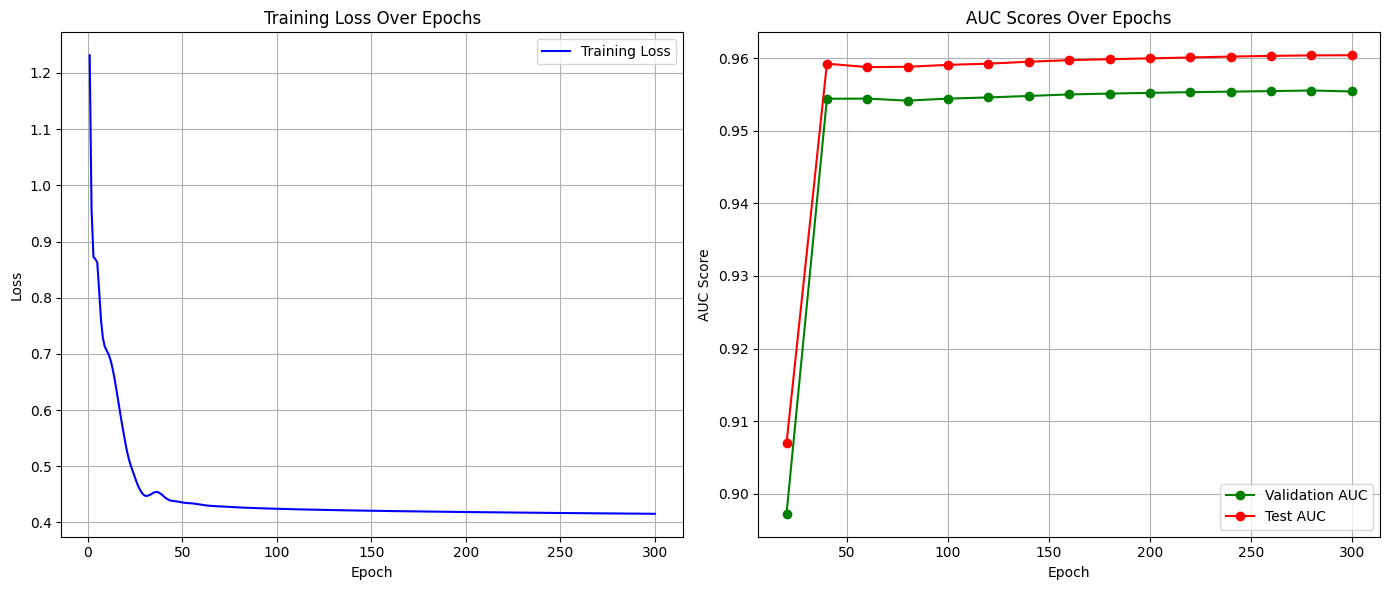

In [ ]:
#evaluating model's performance
plt.figure(figsize=(14, 6))

#training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 301), train_loss_list, color='blue', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()

#auc scores
plt.subplot(1, 2, 2)
plt.plot(epoch_list, val_auc_list, marker='o', color='green', label='Validation AUC')
plt.plot(epoch_list, test_auc_list, marker='o', color='red', label='Test AUC')
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC Scores Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Step 10: Run GNNExplainer on drug-disease predicted links**

In [ ]:
#find the predicted edges

model.eval() #set to eval mode

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    test_scores = model.decode(z, test_data.edge_label_index).sigmoid()

threshold = 0.5 #the default threshold for binary classification
#and only keep edges with pred score > threshold
predicted_edges = test_data.edge_label_index[:, test_scores > threshold]

print(f"Number of predicted edges: {predicted_edges.size(1)}")
print("The predicted edges (source and target indices):")
print(predicted_edges)

Number of predicted edges: 772683
The predicted edges (source and target indices):
tensor([[  4929,  12372,  30094,  ...,  90440,  62625,  89168],
        [152190,  64351,  64962,  ...,  14378,  73679,  90357]],
       device='cuda:0')


In [ ]:
#helpful for our visualizations
#map the node ids to their correct labels
inverted_node_mapping = {mapped: original for original, mapped in node_mapping_fixed.items()}
def get_node_label(mapped_id):
    original_id = inverted_node_mapping.get(mapped_id, None)
    if original_id is None:
        return str(mapped_id)
    return node_label_mapping.get(original_id, str(original_id))

In [ ]:
#load tsv files with drugs and diseases
drug_nodes_path = '/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/drug-nodes.tsv'
disease_nodes_path = '/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/disease-nodes.tsv'

drug_nodes_df = pd.read_csv(drug_nodes_path, sep='\t')
disease_nodes_df = pd.read_csv(disease_nodes_path, sep='\t')

#sets based on entity column
drugs_set = set(drug_nodes_df["ENTITY"].tolist())
diseases_set = set(disease_nodes_df["ENTITY"].tolist())

print("Number of drug nodes:", len(drugs_set))
print("Number of disease nodes:", len(diseases_set))


Number of drug nodes: 19563
Number of disease nodes: 11


In [ ]:
#find the predicted drug-disease edges
drug_disease_edges = []
for i in range(predicted_edges.size(1)):
    edge = predicted_edges[:, i]
    src, dst = edge.tolist()
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    #ensure one node is a drug and the other a disease
    if (label_src in drugs_set and label_dst in diseases_set) or (label_src in diseases_set and label_dst in drugs_set):
         drug_disease_edges.append(edge)

print(f"Number of predicted drug-disease edges: {len(drug_disease_edges)}")

Number of predicted drug-disease edges: 44


In [ ]:
#the model's explanation configurations
model_config = ModelConfig(
    mode='binary_classification', #because we perform a link prediction task
    task_level='edge', #the explanations are focused on edges (link prediction task)
    return_type='raw',
)

#initializing GNNExplainer
explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes', #explains which node attributes are important for the predictions
    edge_mask_type='object', #explains which edges important for the predictions
    model_config=model_config,
)

In [ ]:
#in this loop we precompute constant values, to make code run faster
edges_np = test_data.edge_index.cpu().numpy().T
original_edges_set_global = set(map(tuple, edges_df[['Source', 'Target']].values))

#mapping from csv to relations
edge_relation_mapping_global = {}
for idx, row in edges_df.iterrows():
    src_val = int(row['Source'])
    dst_val = int(row['Target'])
    relation_id = row['Relation_Label']
    relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
    edge_relation_mapping_global[(src_val, dst_val)] = relation_text
    edge_relation_mapping_global[(dst_val, src_val)] = relation_text

#threshold for including edges from the explanation mask
threshold = 1e-3

#list to keep data for the final csv
explanations_data = []

In [ ]:
#GNNExplainer on each drug–disease predicted edge
#for edge in drug_disease_edges[:1]: #<------------CUSTOM for debugging
for edge in drug_disease_edges:
    edge_label_index = edge.unsqueeze(1) #shape (2,1)
    explanation = explainer(
         x=test_data.x,
         edge_index=test_data.edge_index,
         edge_label_index=edge_label_index,
    )

    #predicted probability for the current edge
    pred_prob = model.decode(z, edge_label_index).sigmoid().item()

    #from tensor to int
    src_mapped_id = edge[0].item()
    dst_mapped_id = edge[1].item()

    src_label = get_node_label(src_mapped_id)
    dst_label = get_node_label(dst_mapped_id)

    print(f"Explained edge: {src_label} -> {dst_label}, Predicted probability: {pred_prob:.4f}")


    #VISUALIZATION 1: FEATURE IMPORTANCE
    ################################################################
    node_mask = explanation.node_mask.cpu().detach().numpy()
    if node_mask.ndim > 1:
        node_importance = node_mask.sum(axis=1)
    else:
        node_importance = node_mask

    top_k = 10
    top_indices = np.argsort(-node_importance)[:top_k]
    top_importances = node_importance[top_indices]
    top_labels = [get_node_label(idx) for idx in top_indices]

    #final csv columns: Node_A, Node_B, Predicted Probability
    row_data = [src_label, dst_label, pred_prob]

    for i in range(len(top_labels)):
        row_data.append(top_labels[i])
        row_data.append(float(top_importances[i]))

    explanations_data.append(row_data)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(top_k), top_importances, tick_label=top_labels)

    plt.gca().invert_yaxis() #to show the most important node on top

    #font size 9 for readability
    plt.yticks(fontsize=9)
    plt.xticks(fontsize=9)

    for bar in bars:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        plt.text(width + 0.02, y_pos, f"{width:.3f}", va='center', ha='left')
    plt.xticks(rotation=45, ha="right")
    plt.title("Feature Importance for Top 10 Nodes")
    plt.xlabel("Importance", fontsize=10)
    plt.ylabel("Node Label", fontsize=10)
    plt.tight_layout()

    fi_filename = os.path.join(feature_importance_dir, f"FI_{src_label}_LINKED_{dst_label}.png")
    plt.savefig(fi_filename, bbox_inches='tight', pad_inches=0.5)
    plt.close()
    print(f"Feature importance plot saved to: {fi_filename}")


    #VISUALIZATION 2: PyVis EXPLANATION GRAPH (HTML)
    ################################################################
    edge_list = []
    nodes_in_graph = set()
    for i, (src, dst) in enumerate(edges_np):
        if (src, dst) in original_edges_set_global or (dst, src) in original_edges_set_global:
            if src in important_nodes and dst in important_nodes:
                weight = float(edge_mask[i])
                relation_text = edge_relation_mapping.get((int(src), int(dst)), "Relation None")
                edge_list.append((int(src), int(dst), weight, relation_text))
                nodes_in_graph.add(int(src))
                nodes_in_graph.add(int(dst))

    #if no edges are found, the link will be "Explained Edge"
    if len(nodes_in_graph) == 0:
        explained_src = int(edge[0].item())
        explained_dst = int(edge[1].item())
        edge_list.append((explained_src, explained_dst, 1.0, "Explained Edge"))
        nodes_in_graph.add(explained_src)
        nodes_in_graph.add(explained_dst)

    node_labels_pyvis = {}
    for node in nodes_in_graph:
        if node in node_mapping_fixed.values():
            original_id = list(node_mapping_fixed.keys())[list(node_mapping_fixed.values()).index(node)]
        else:
            original_id = None
        if original_id is not None:
            label = node_label_mapping.get(original_id, str(original_id))
            node_labels_pyvis[node] = label if not pd.isna(label) else str(original_id)
        else:
            node_labels_pyvis[node] = str(node)

    node_importance_pyvis = {node: node_importance_array[node] for node in nodes_in_graph if node < len(node_importance_array)}
    node_vals = list(node_importance_pyvis.values())
    if node_vals:
        min_node_val, max_node_val = min(node_vals), max(node_vals)
    else:
        min_node_val, max_node_val = 0, 1
    node_norm = mcolors.Normalize(vmin=min_node_val, vmax=max_node_val)
    reds = plt.cm.Reds

    net = Network(height="800px", width="1000px", bgcolor="white", font_color="black", cdn_resources="remote")
    net.barnes_hut(gravity=-5000,
                   central_gravity=0.1,
                   spring_length=250,
                   spring_strength=0.008,
                   damping=0.09,
                   overlap=0.5)
    for n in nodes_in_graph:
        label = node_labels_pyvis.get(n, str(n))
        imp = node_importance_pyvis.get(n, 0)
        node_color = mcolors.to_hex(reds(node_norm(imp)))
        net.add_node(n, label=label, title=label, size=50, color=node_color,
                     font={"size": 18, "color": "black", "bold": True})
    min_threshold_pyvis = 0.3
    edge_vals = [w for (_, _, w, _) in edge_list]
    if edge_vals:
        min_edge_val, max_edge_val = min(edge_vals), max(edge_vals)
    else:
        min_edge_val, max_edge_val = 0, 1
    edge_norm = mcolors.Normalize(vmin=min_edge_val, vmax=max_edge_val)
    blues = plt.cm.Blues
    for (src, dst, weight, relation_text) in edge_list:
        norm_value = edge_norm(weight)
        norm_value = max(norm_value, min_threshold_pyvis)
        edge_color = mcolors.to_hex(blues(norm_value))
        net.add_edge(src, dst, value=weight, width=weight * 5, color=edge_color,
                     title=relation_text, label=relation_text,
                     font={"size": 18, "color": "black", "bold": True})
    pyvis_filename = os.path.join(pyvis_explanation_graph_dir, f"PVEXPGR_{src_label}_LINKED_{dst_label}.html")

    #editing the html file to add title
    if src_label in drugs_set and dst_label in diseases_set:
        title_str = f"drug: {src_label} --> disease: {dst_label}"
    elif src_label in diseases_set and dst_label in drugs_set:
        title_str = f"disease: {src_label} --> drug: {dst_label}"
    else:
        title_str = f"{src_label} --> {dst_label}"

    pyvis_filename = os.path.join(pyvis_explanation_graph_dir, f"PVEXPGR_{src_label}_LINKED_{dst_label}.html")
    net.save_graph(pyvis_filename)
    print(f"PyVis explanation graph saved to: {pyvis_filename}")

    with open(pyvis_filename, 'r') as file:
        html_content = file.read()

    html_content = html_content.replace("<body>", f"<body>\n<h2 style='text-align: left;'>{title_str}</h2>\n")

    with open(pyvis_filename, 'w') as file:
      file.write(html_content)

Explained edge: Myotonic Dystrophy -> Clomipramine, Predicted probability: 1.0000
Feature importance plot saved to: /content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results/feature_importance_12042025_2148/FI_Myotonic Dystrophy_LINKED_Clomipramine.png
Filtered explanation graph saved to: /content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results/explanation_graph_12042025_2148/EXPGR_Myotonic Dystrophy_LINKED_Clomipramine.png
PyVis explanation graph saved to: /content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results/pyvis_explanation_graph_12042025_2148/PVEXPGR_Myotonic Dystrophy_LINKED_Clomipramine.html
Explained edge: Riboflavin -> Glutaric aciduria, type 1, Predicted probability: 1.0000
Feature importance plot saved to: /content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results/feature_importance_12042025_2148/FI_Riboflavin_LINKED_Glutaric aciduria, type 1.png
Filtered explanation graph saved to: /content/

In [ ]:
#saving the results in a csv file
base_cols = ["Node_A", "Node_B", "Predicted_Probability"]
extra_cols = []
for i in range(top_k):
    extra_cols.append(f"Node_{i+1}")
    extra_cols.append(f"Score_{i+1}")

all_columns = base_cols + extra_cols
df_explanations = pd.DataFrame(explanations_data, columns=all_columns)

csv_filename = os.path.join(results_dir, f"drug_disease_explanations_{timestamp_str}.csv")
df_explanations.to_csv(csv_filename, index=False)
print(f"Saved explanations to: {csv_filename}")

Saved explanations to: /content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/FULL GRAPH/results/drug_disease_explanations_12042025_2148.csv
